In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7773843996692944185
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14343274496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8528691356934342405
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Add, Dense, Flatten, SeparableConv2D, Dropout, Activation, ReLU, BatchNormalization, MaxPool2D, GlobalAvgPool2D
from keras.layers.convolutional import Conv2D, AveragePooling2D, ZeroPadding2D 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
import keras.backend as K
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from PIL import Image
import glob
from google.colab import files

In [14]:
#Назва файлу з навченою нейронною мережею
NN_name = "NN_Lab10.h5" 

# Каталог із даними для навчання
train_dir = "/content/gdrive/My Drive/train"

# Каталог із даними для тестування
test_dir = "/content/gdrive/My Drive/test"

# Розміри зображення для навчання нейронної мережі
img_width, img_height = 299, 299

# Глибина зображення RGB = 3
DEPTH = 3

# Розмірність тензора на основі зображення для вхідних даних у нейронну мережу
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, DEPTH)

# Кількість епох навчання
epochs = 10
# Розмір міні-вибірки
batch_size = 32  

LEARNING_RATE = 0.0005

In [5]:
#Каталог з даними для навчання, де є об'єкт
train_dir_logo = glob.glob("/content/gdrive/My Drive/train/logo/*.jpg")
TrainData = []

for file in train_dir_logo:
    img = Image.open(file).convert('RGB')
    img = img.resize((img_width, img_height))
    imgarray = np.asarray(img)
    TrainData.append((imgarray,1))

#Каталог з даними для навчання, де немає об'єкт
train_dir_No_logo = glob.glob("/content/gdrive/My Drive/train/No_logo/*.jpg")

for file in train_dir_No_logo:
    img = Image.open(file).convert('RGB')
    img = img.resize((img_width, img_height))
    imgarray = np.asarray(img)
    TrainData.append((imgarray,0))

print("Навчальні дані оброблені")

random.shuffle(TrainData)

Навчальні дані оброблені


In [6]:
TrainData

[(array([[[ 67, 103, 128],
          [ 68, 105, 131],
          [ 69, 106, 133],
          ...,
          [179, 208, 216],
          [193, 219, 225],
          [204, 228, 233]],
  
         [[ 67, 103, 128],
          [ 68, 104, 131],
          [ 69, 105, 133],
          ...,
          [188, 218, 226],
          [207, 234, 241],
          [214, 239, 245]],
  
         [[ 67, 103, 129],
          [ 69, 104, 131],
          [ 70, 105, 133],
          ...,
          [189, 222, 230],
          [195, 224, 232],
          [195, 222, 230]],
  
         ...,
  
         [[ 36,  29,  18],
          [ 27,  19,  10],
          [ 19,   9,   2],
          ...,
          [ 71,  48,  25],
          [ 75,  48,  24],
          [ 62,  41,  12]],
  
         [[ 37,  30,  20],
          [ 49,  42,  33],
          [ 27,  20,  12],
          ...,
          [ 68,  47,  22],
          [ 74,  48,  23],
          [ 58,  38,   8]],
  
         [[ 19,  12,   4],
          [ 36,  29,  21],
          [ 41,  34,  27

In [7]:
#Каталог з даними для тестування, де є об'єкт
test_dir_logo = glob.glob("/content/gdrive/My Drive/test/logo/*.jpg")

TestData = []

for file in test_dir_logo:
    img = Image.open(file).convert('RGB')
    img = img.resize((img_width, img_height))
    imgarray = np.asarray(img)
    TestData.append((imgarray,1))

#Каталог з даними для тестування де немає об'єкту
test_dir_No_logo = glob.glob("/content/gdrive/My Drive/test/No_logo/*.jpg")

for file in test_dir_No_logo:
    img = Image.open(file).convert('RGB')
    img = img.resize((img_width, img_height))
    imgarray = np.asarray(img)
    TestData.append((imgarray, 0))

print("Тестові дані опрацьовані")

random.shuffle(TestData)

Тестові дані опрацьовані


In [8]:
TestData

[(array([[[20, 15,  9],
          [19, 14,  8],
          [17, 12,  6],
          ...,
          [31, 24, 18],
          [26, 20, 14],
          [24, 19, 13]],
  
         [[20, 15,  9],
          [20, 15,  9],
          [20, 15,  9],
          ...,
          [31, 24, 18],
          [26, 20, 14],
          [24, 19, 13]],
  
         [[18, 13,  7],
          [19, 14,  8],
          [21, 16, 10],
          ...,
          [31, 24, 18],
          [27, 20, 14],
          [24, 19, 13]],
  
         ...,
  
         [[14,  2,  1],
          [14,  3,  2],
          [42, 30, 23],
          ...,
          [72, 54, 47],
          [64, 46, 38],
          [77, 59, 48]],
  
         [[22, 12, 11],
          [12,  3,  3],
          [15,  5,  1],
          ...,
          [62, 47, 42],
          [48, 34, 26],
          [67, 54, 44]],
  
         [[27, 17, 16],
          [22, 13, 11],
          [11,  2,  0],
          ...,
          [53, 39, 36],
          [38, 25, 18],
          [61, 49, 39]]], dtype=u

In [9]:
print("TrainData ",len(TrainData))
print("TestData ",len(TestData))

Train_X = np.array([item[0] for item in TrainData])
Train_Y = np.array([item[1] for item in TrainData])

Test_X = np.array([item[0] for item in TestData])
Test_Y = np.array([item[1] for item in TestData])

Train_X = Train_X.astype('float32')
Test_X = Test_X.astype('float32')

Train_X /= 255
Test_X /= 255

TrainData  6618
TestData  1552


In [10]:
Train_X[0]

array([[[0.2627451 , 0.40392157, 0.5019608 ],
        [0.26666668, 0.4117647 , 0.5137255 ],
        [0.27058825, 0.41568628, 0.52156866],
        ...,
        [0.7019608 , 0.8156863 , 0.84705883],
        [0.75686276, 0.85882354, 0.88235295],
        [0.8       , 0.89411765, 0.9137255 ]],

       [[0.2627451 , 0.40392157, 0.5019608 ],
        [0.26666668, 0.40784314, 0.5137255 ],
        [0.27058825, 0.4117647 , 0.52156866],
        ...,
        [0.7372549 , 0.85490197, 0.8862745 ],
        [0.8117647 , 0.91764706, 0.94509804],
        [0.8392157 , 0.9372549 , 0.9607843 ]],

       [[0.2627451 , 0.40392157, 0.5058824 ],
        [0.27058825, 0.40784314, 0.5137255 ],
        [0.27450982, 0.4117647 , 0.52156866],
        ...,
        [0.7411765 , 0.87058824, 0.9019608 ],
        [0.7647059 , 0.8784314 , 0.9098039 ],
        [0.7647059 , 0.87058824, 0.9019608 ]],

       ...,

       [[0.14117648, 0.11372549, 0.07058824],
        [0.10588235, 0.07450981, 0.03921569],
        [0.07450981, 0

Варіант розподілу на навчальну і тестову вибірку

In [ ]:
from sklearn.model_selection import train_test_split
Train_X2, Test_X2, Train_Y2, Test_Y2 = train_test_split(Train_X, Train_Y, test_size=0.1, random_state=42, stratify=Train_Y)

Другий варіант створення навчального датасета!

In [5]:
print("Старт обробки даних для навчання!" )

df_train = pd.DataFrame(columns=['Train_X', 'Train_Y'])


#Каталог з даними де є об'єкт
train_dir_logo = glob.glob("/content/gdrive/My Drive/train/logo/*.jpg")

for file in train_dir_logo:
    df_train.loc[len(df_train)] = [file, 1]
    

#Каталог з даними де немає об'єкта
train_dir_No_logo = glob.glob("/content/gdrive/My Drive/train/No_logo/*.jpg")


for file in train_dir_No_logo:
    df_train.loc[len(df_train)] = [file, 0]
     
df_train = df_train.sample(frac=1).reset_index(drop=True)

print("Навчальні дані оброблені")

df_test = pd.DataFrame(columns=['Test_X', 'Test_Y'])

#Каталог з даними для тестування де є об'єкт
test_dir_logo = glob.glob("/content/gdrive/My Drive/test/logo/*.jpg")

for file in test_dir_logo:
    df_test.loc[len(df_test)] = [file, 1]
    

#Каталог з даними для тестування де немає об'єкт
test_dir_No_logo = glob.glob("/content/gdrive/My Drive/test/No_logo/*.jpg")

for file in test_dir_No_logo:
    df_test.loc[len(df_test)] = [file, 0]
    
df_test = df_test.sample(frac=1).reset_index(drop=True)
print("Тестові дані оброблені!")

Старт обробки даних для навчання!
Навчальні дані оброблені
Тестові дані оброблені!


In [6]:
df_train

Train_X  Train_Y
0     /content/gdrive/My Drive/train/No_logo/No_logo...        0
1     /content/gdrive/My Drive/train/No_logo/No_logo...        0
2     /content/gdrive/My Drive/train/No_logo/No_logo...        0
3     /content/gdrive/My Drive/train/logo/logo_2032.jpg        1
4     /content/gdrive/My Drive/train/No_logo/No_logo...        0
...                                                 ...      ...
6613  /content/gdrive/My Drive/train/No_logo/No_logo...        0
6614  /content/gdrive/My Drive/train/No_logo/No_logo...        0
6615  /content/gdrive/My Drive/train/logo/logo_3966.jpg        1
6616  /content/gdrive/My Drive/train/logo/logo_4068.jpg        1
6617  /content/gdrive/My Drive/train/logo/No_logo_47...        1

[6618 rows x 2 columns]

In [7]:
df_test

Test_X  Test_Y
0      /content/gdrive/My Drive/test/logo/logo_4888.jpg       1
1      /content/gdrive/My Drive/test/logo/logo_4938.jpg       1
2     /content/gdrive/My Drive/test/No_logo/No_logo_...       0
3      /content/gdrive/My Drive/test/logo/logo_4419.jpg       1
4     /content/gdrive/My Drive/test/No_logo/No_logo_...       0
...                                                 ...     ...
1547   /content/gdrive/My Drive/test/logo/logo_4962.jpg       1
1548   /content/gdrive/My Drive/test/logo/logo_4511.jpg       1
1549   /content/gdrive/My Drive/test/logo/logo_4866.jpg       1
1550   /content/gdrive/My Drive/test/logo/logo_4723.jpg       1
1551   /content/gdrive/My Drive/test/logo/logo_4871.jpg       1

[1552 rows x 2 columns]

In [8]:
def DATA(filename, label):
        
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    resize_image = tf.image.resize(image_decoded, [299, 299])
    image = tf.cast(resize_image, tf.float32)
    image = image / 255 
   
    return image, label

In [15]:
# Створюємо навчальний датасет

train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train['Train_X']), list(df_train['Train_Y']))
)

train_dataset = (
    train_dataset.map(DATA, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Створюємо тестовий датасет
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_test['Test_X']), list(df_test['Test_Y']))
)
validation_dataset = (
    validation_dataset.map(DATA, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Створення нейронної мережі

In [10]:
print("Створюємо нейронну мережу AlexNet")
     
model = keras.models.Sequential([
    #Вхідний блок, що складається з 96 фільтрів
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape = input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')])
    
    #Компілюємо нейронну мережу
opt = keras.optimizers.Adam(LEARNING_RATE)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['accuracy'])
   
print("Нейронна мережа створена!")    


Створюємо нейронну мережу AlexNet
Нейронна мережа створена!


Архітектура нейронної мережі текстом.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 35, 35, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 17, 17, 256)      1024      
 hNormalization)                                                 
                                                        

Зображення архітектури нейронної мережі

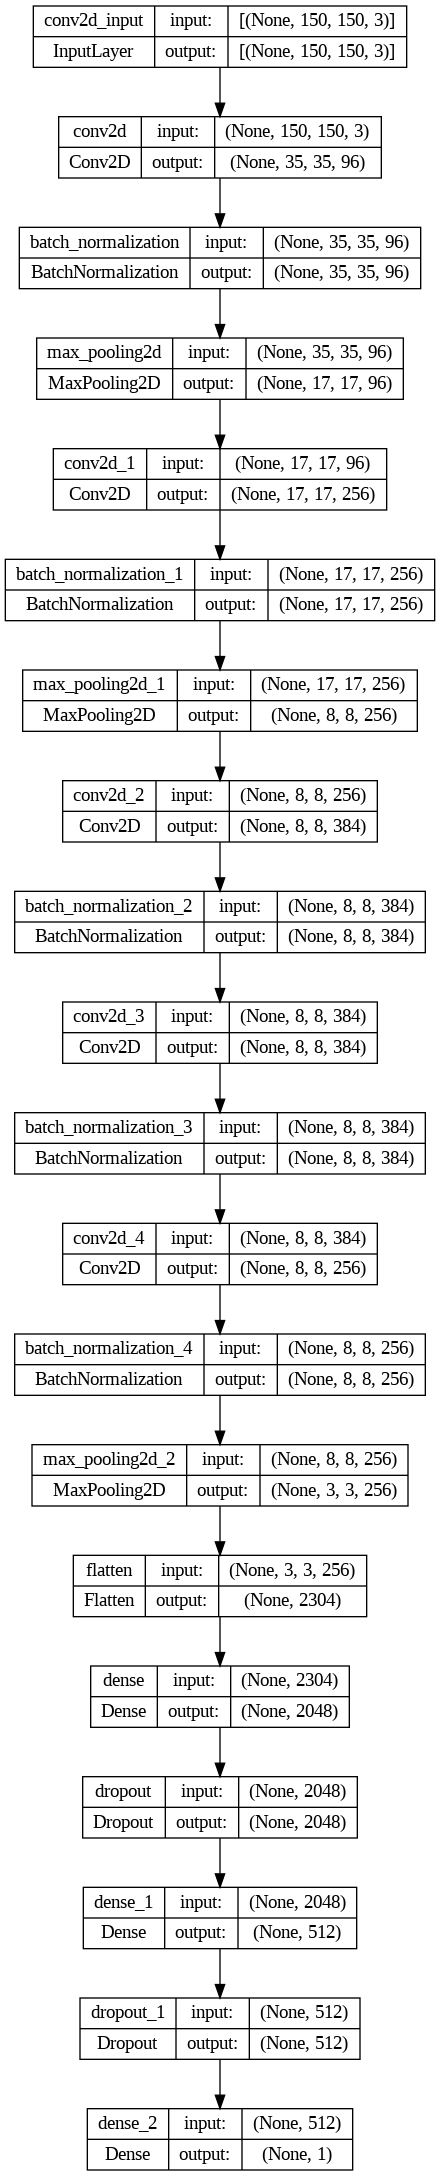

In [13]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

Перший варіант навчання.

In [14]:
print("Старт навчання нейронної мережі!")
   
model_save_path = "/content/gdrive/My Drive/" + NN_name
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
    
#Навчаємо нейромережу 
model.fit(
            Train_X,
            Train_Y, 
            batch_size = batch_size, 
            epochs = epochs, 
            validation_split=0.1,
            callbacks=[checkpoint_callback])

Старт навчання нейронної мережі!
Epoch 1/10
373/373 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.7817
Epoch 1: val_accuracy improved from -inf to 0.64955, saving model to /content/gdrive/My Drive/NN_Lab10.h5
373/373 [==============================] - 32s 44ms/step - loss: 0.7406 - accuracy: 0.7817 - val_loss: 1.2526 - val_accuracy: 0.6495
Epoch 2/10
370/373 [============================>.] - ETA: 0s - loss: 0.2895 - accuracy: 0.8944
Epoch 2: val_accuracy improved from 0.64955 to 0.87160, saving model to /content/gdrive/My Drive/NN_Lab10.h5
373/373 [==============================] - 7s 19ms/step - loss: 0.2904 - accuracy: 0.8941 - val_loss: 0.3235 - val_accuracy: 0.8716
Epoch 3/10
372/373 [============================>.] - ETA: 0s - loss: 0.2245 - accuracy: 0.9209
Epoch 3: val_accuracy improved from 0.87160 to 0.88218, saving model to /content/gdrive/My Drive/NN_Lab10.h5
373/373 [==============================] - 6s 17ms/step - loss: 0.2244 - accuracy: 0.9209 

Другий варіант навчання!

In [16]:
print("Старт навчання нейронної мережі!")
   
model_save_path = "/content/gdrive/My Drive/" + NN_name
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
    
#Навчаємо нейромережу 
model.fit(
            train_dataset,
            validation_data=validation_dataset, 
            epochs = epochs, 
            callbacks=[checkpoint_callback])

Старт навчання нейронної мережі!
Epoch 1/10
 24/207 [==>...........................] - ETA: 7:26 - loss: 2.9166 - accuracy: 0.7526

KeyboardInterrupt: ignored

Варіант оцінки №1

In [15]:
from keras.models import load_model
model = load_model("/content/gdrive/My Drive/" + NN_name)

# Оцінимо модель на тестових даних, використовуючи "evaluate"
print("Оцінюємо на тестових даних")

scores = model.evaluate(Test_X, Test_Y, batch_size = batch_size)

print("test loss, test acc:", scores)


Оцінюємо на тестових даних
97/97 [==============================] - 1s 8ms/step - loss: 0.0367 - accuracy: 0.9884
test loss, test acc: [0.036722809076309204, 0.9884020686149597]


Варіант оцінки №2

In [ ]:
from keras.models import load_model
model = load_model("/content/gdrive/My Drive/" + NN_name)

print("на тестовых данных")
scores = model.evaluate(validation_dataset)
print("test loss, test acc:", scores)

TestData  1552
Тестові дані опрацьовані
49/49 [==============================] - 1s 13ms/step


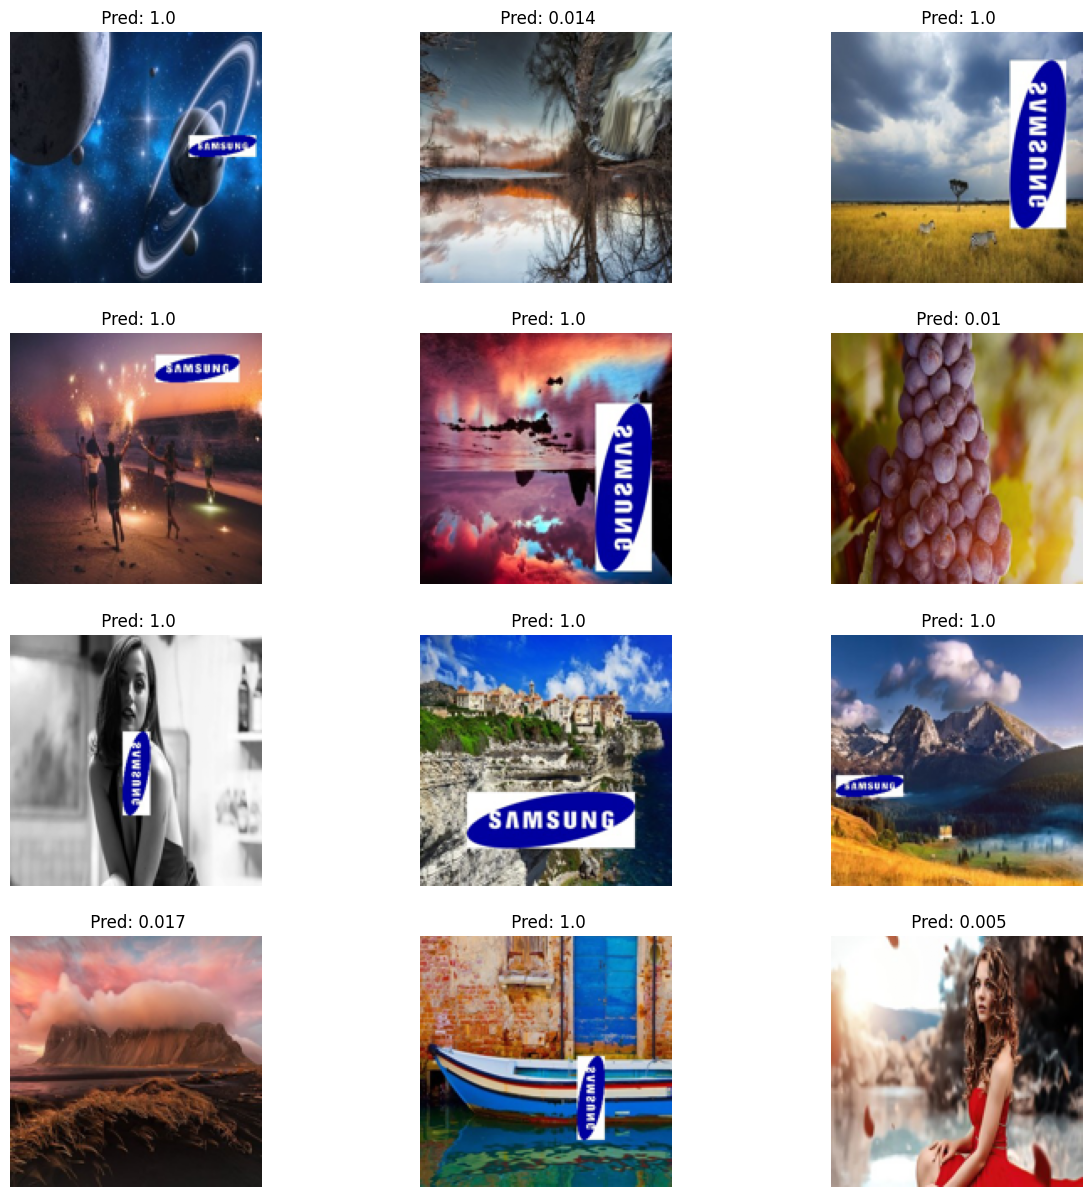

In [17]:
from keras.models import load_model
from keras import backend as K

model = load_model("/content/gdrive/My Drive/" + NN_name)

img_width, img_height = 150, 150

#Каталог з даними для тестування, де є об'єкт
test_dir_logo = glob.glob("/content/gdrive/My Drive/test/logo/*.jpg")

TestData = []

for file in test_dir_logo:
    img = Image.open(file).convert('RGB')
    img = img.resize((img_width, img_height))
    imgarray = np.asarray(img)
    TestData.append((imgarray,1))

#Каталог з даними для тестування де немає об'єкту
test_dir_No_logo = glob.glob("/content/gdrive/My Drive/test/No_logo/*.jpg")

for file in test_dir_No_logo:
    img = Image.open(file).convert('RGB')
    img = img.resize((img_width, img_height))
    imgarray = np.asarray(img)
    TestData.append((imgarray, 0))



random.shuffle(TestData)

print("TestData ",len(TestData))

Test_X = np.array([item[0] for item in TestData])
Test_Y = np.array([item[1] for item in TestData])
Test_X = Test_X.astype('float32')
Test_X /= 255

print("Тестові дані опрацьовані")


Predictions = model.predict(Test_X)
plt.figure(figsize=(15, 15))
# а - 
a = 0
for i in range(0,12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(Test_X[i+a])
        plt.title(" Pred: "+str(round(Predictions[i+a][0], 3)))
        plt.axis("off")


In [18]:
Predictions

array([[0.9999145 ],
       [0.01441766],
       [0.9995691 ],
       ...,
       [0.9978873 ],
       [0.3024735 ],
       [0.00196674]], dtype=float32)

In [19]:
print(len(Predictions))

1552


In [20]:
Predictions[0][0]

0.9999145

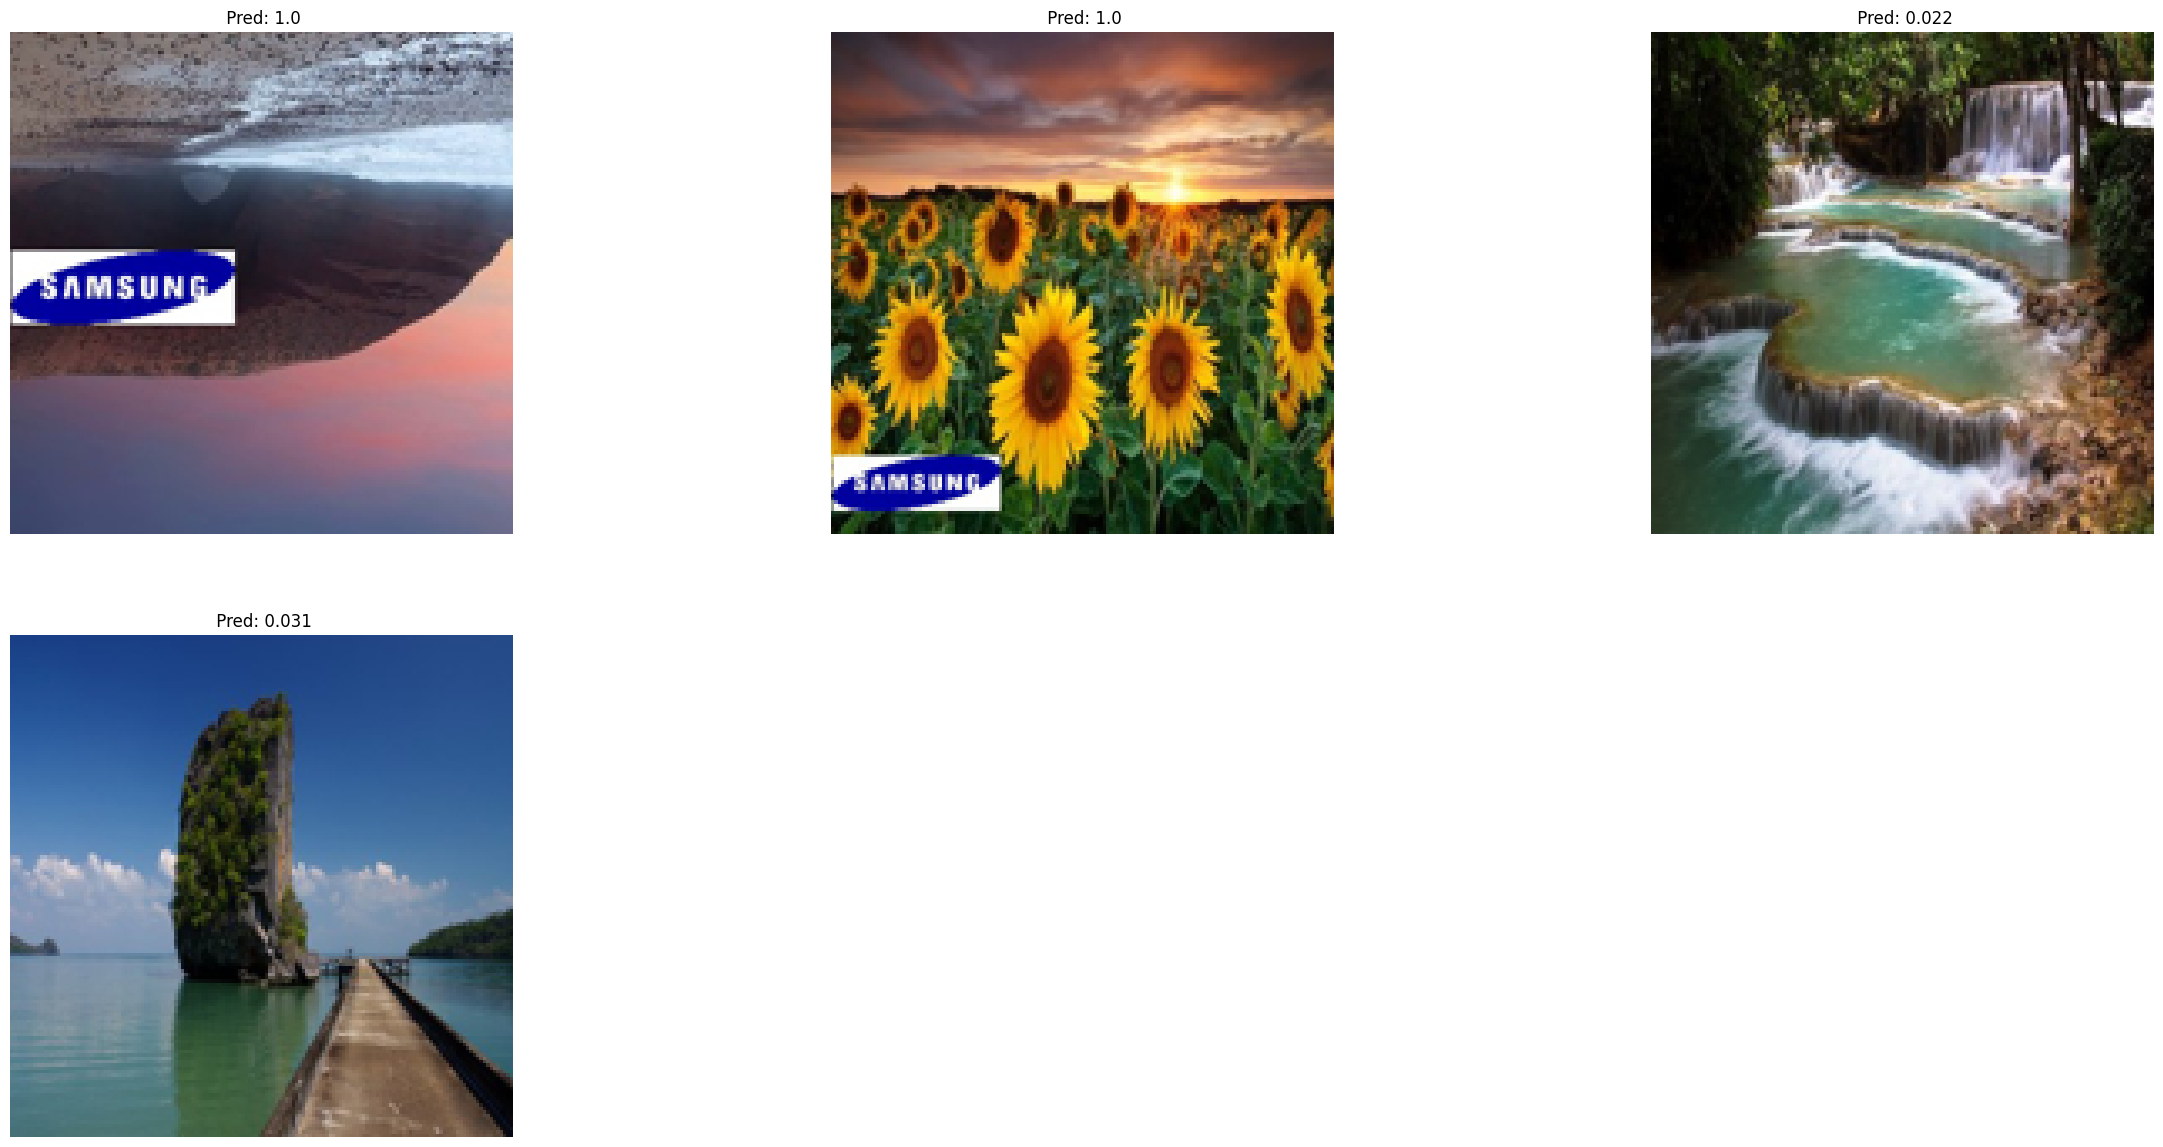

In [21]:
plt.figure(figsize=(30, 30))
a = 200
for i in range(0, 4):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(Test_X[i+a])
        plt.title(" Pred: "+str(round(Predictions[i+a][0], 3)))
        plt.axis("off")

Обробка одного зображення

1/1 [==============================] - 0s 366ms/step


(-0.5, 149.5, 149.5, -0.5)

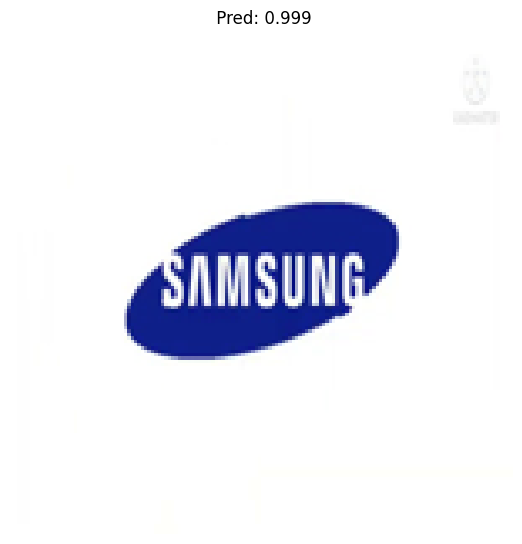

In [23]:
from keras.models import load_model
from keras import backend as K

model = load_model("/content/gdrive/My Drive/" + "NN_Lab10.h5")

TestData=[]
img = Image.open("/content/gdrive/My Drive/train/logo/1frame1044.jpg").convert('RGB')
img = img.resize((150, 150))
imgarray = np.asarray(img)
TestData.append(imgarray)
Test_X = np.array(TestData)
Test_X = Test_X.astype('float32')
Test_X /= 255
       
# Розпізнавання зображення
Predictions = model.predict(Test_X)


plt.figure(figsize=(30, 30))
ax = plt.subplot(4, 3, 1)
plt.imshow(np.squeeze(Test_X))
plt.title(" Pred: "+str(round(Predictions[0][0], 3)))
plt.axis("off")

Приклад обробки відео

In [24]:
from keras.models import load_model
import cv2
import numpy as np
import pandas as pd
from keras.preprocessing import image
import os

# Розміри зображення
img_width, img_height = 150, 150

print("Старт роботи програми!")


#Завантаження навченої нейронної мережі
model = load_model("/content/gdrive/My Drive/NN_Lab10.h5") 

#Функція обробки окремих зображень/кадрів
def predict_from_image(img_path):
    
    # Підготовка зображення до обробки нейронною мережею
    TestData=[]        
    img = tf.keras.utils.load_img(img_path, target_size=(img_width, img_height)).convert('RGB')
    imgarray = np.asarray(img)
    TestData.append(imgarray)
    Test_X = np.array(TestData)
    Test_X = Test_X.astype('float32')
    Test_X /= 255
        
    # Розпізнавання зображення
    res = model.predict(Test_X)
    return res[0][0]

#Завантаження відео
video_path = "/content/gdrive/My Drive/" + "SAMSUNG.mp4"

cap = cv2.VideoCapture(video_path)

if (cap.isOpened()== False):
    print("Error opening video stream or file")

frame_no = 0
hasLogo = False
appearCount = 0
dates = []

No_logo_in_video = True
DFVideo = pd.DataFrame(columns=["FrameNo", "Probability"])
count = 0

#Змінні для підрахунку часу з якого по який знайдено об'єкт
time_Yes_logo = ""
Detected = False
firt_run = True

#Старт обробки відео
print("Йдео обробка відео. Очікуйте!")

while(cap.isOpened()):
    hasLogo = False
    frame_exists, curr_frame = cap.read()
    
    #Обробляємо всі зображення
    if frame_exists:
        
        #Встановлення значення через скільки кадрів відео перевіряємо наявність об'єкта 
        #Якщо кожен кадр frame_no % 1 == 0
        #Якщо кожен 4-й кадр frame_no % 4 == 0
        #Якщо 10-й кадр frame_no % 10 == 0
        
        if frame_no % 4 == 0:
            
            cv2.imwrite("frame%d.jpg" % frame_no, curr_frame) 
            
            probability = predict_from_image("frame%d.jpg" %frame_no)
                        
            timeF = cap.get(cv2.CAP_PROP_POS_MSEC)
            timeF = timeF / 1000

            #Вивід на екран номера і часу кожного кадру що обробляється
            
            #print("for frame : " + str(frame_no) + " timestamp is: ", str(round(timeF, 2)) + "s")

            #Нейромережа повертає значення вірогідності знаходження об'єкта на кадрі від 0 до 1
            #0 - сама низька вірогідність
            #1 - сама висока вірогідність
            # Якщо вірогідність > 0.5 - є логотип, якщо меньше - немає логотипу 
           
            if probability < 0.5:
                hasLogo = False
                if hasLogo == False:
                    
                    #Вивід на екран номера і часу кожного кадру де немає об'єкта та результату обробки його нейромережею                   

                    #print("for frame : " + str(frame_no) + " timestamp is: ", str(round(timeF, 2)) + "s", " Is not detected: ", probability))
                    
                                     
                    if firt_run == False:
                        if Detected == False : 
                            time_Yes_logo += " To : " + str(round(timeF, 2)) + "\n"
                            Detected = True

                    #Видаляємо тимчасово збережене зображення 
                    #щоб його зберегти в поточну папку, потрібно закоментувати наступну команду
                    os.remove("frame%d.jpg" % frame_no)
                                   

            if probability >= 0.5 :
                hasLogo = True
                firt_run = False
                No_logo_in_video = False
                
                #Вивід на екран номера і часу кожного кадру де є об'єкт та результату обробки його нейромережею

                #print("for frame : " + str(frame_no) + " timestamp is: ", str(round(timeF, 2)) + "s", " Is detected: ", probability)
                
                if hasLogo == True:
                    appearCount += 1
                    dates.append(str(round(timeF, 2)))
                   
                    if Detected == True : 
                        time_Yes_logo += "From : " + str(round(timeF, 2))
                        Detected = False
                
                                
                #Удалить изображение с логотипом, 
                #что бы его сохранить в текущую папку нужно закоментировать следующую команду
                os.remove("frame%d.jpg" % frame_no)
                
                hasLogo = False
            DFVideo.loc[count] = ["frame%d.jpg" % frame_no, probability]
            count = count + 1
    else:
        break
    frame_no += 1

#Якщо об'єкт не знайдено на відео
if No_logo_in_video == True:
    print("No logo / product found on video !!!")


#Виведення кількості кадрів із розпізнаним об'єктом
print("The logo was found on the following number of frames : " + str(appearCount))

#Виведення на екран результату кожного кадру, де є об'єкт
#Якщо потрібно переглянути - розкоментувати наступну команду

#print("Times of appearences: ", dates)

#Виведення на екран тимчасових міток, з якої секунди по яку з'являвся об'єкт 
print("Display of timestamps, from what second to what second the logo / product appeared:")
print(time_Yes_logo)

cap.release()

Старт роботи програми!
Йдео обробка відео. Очікуйте!
1/1 [==============================] - 0s 26ms/step
The logo was found on the following number of frames : 136
Display of timestamps, from what second to what second the logo / product appeared:
 To : 2.67
From : 3.34 To : 3.5
From : 4.0 To : 4.17
From : 8.84 To : 9.18
From : 9.34 To : 9.84
From : 10.01 To : 10.34
From : 10.51 To : 11.68
From : 15.52 To : 18.52
From : 26.86 To : 27.03
From : 28.53 To : 32.87
From : 42.71 To : 48.88
From : 51.72 To : 52.89
From : 54.22 To : 57.56
From : 83.58
